# The goal of this notebook is to find the polarity of the checkerboard stimulus displayed on the retina on different setups

In [7]:
import numpy as np
import matplotlib.pyplot as plt

laptop = True
tower = False

 # MEA 2

Here are the first two frames, seen on the camera

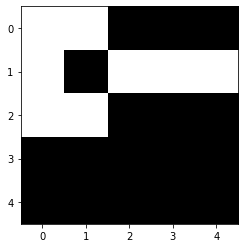

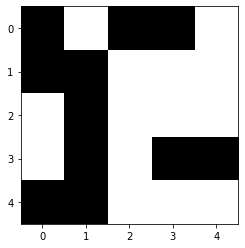

In [14]:
first_frame_camera = np.array([[1,1,0,0,0],
                             [1,0,1,1,1],
                             [1,1,0,0,0],
                             [0,0,0,0,0],
                             [0,0,0,0,0]])

second_frame_camera = np.array([[0,1,0,0,1],
                             [0,0,1,1,1],
                             [1,0,1,1,1],
                             [1,0,1,0,0],
                             [0,0,1,1,1]])

plt.figure()
plt.imshow(first_frame_camera, cmap='gray')

plt.figure()
plt.imshow(second_frame_camera, cmap='gray')

The checkerboard stimulus is constructed from the file binarysource1000Mbits, that contains a series of 0 and 1. 0 is supposed to correspond to black, and 1 to white, in the stimulus that is projected on the retina.

The checkerboard stimulus can be reconstructed using the Checkerboard class

In [15]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.gridspec as gds
import matplotlib.pyplot as plt
import pickle

class Checkerboard:

    def __init__(self, nb_checks, binary_source_path, rig_nb, repetitions, triggers):

        assert os.path.isfile(binary_source_path)

        self._nb_checks = nb_checks
        self._binary_source_path = binary_source_path
        self._rig_nb = rig_nb
        self._repetitions = repetitions
        self._triggers = triggers

        self._binary_source_file = open(self._binary_source_path, mode='rb')


    def __exit__(self, exc_type, exc_value, traceback):

        self._input_file.close()

        return

    def get_limits(self):

        return self._triggers.get_limits()

    def get_repetition_limits(self):

        start_trigger_nbs = self._repetitions.get_start_trigger_nbs(condition_nb=0)
        end_trigger_nbs = self._repetitions.get_end_trigger_nbs(condition_nb=0)

        start_sample_nbs = self._triggers.get_sample_nbs(start_trigger_nbs)
        end_sample_nbs = self._triggers.get_sample_nbs(end_trigger_nbs)

        repetition_limits = [
            (start_sample_nb, end_sample_nb)
            for start_sample_nb, end_sample_nb in zip(start_sample_nbs, end_sample_nbs)
        ]

        return repetition_limits

    def get_image_nbs(self, sample_nbs):

        trigger_nbs = self._triggers.get_trigger_nbs(sample_nbs)

        sequence_length = 300  # frames

        image_nbs = np.copy(trigger_nbs)
        for k, trigger_nb in enumerate(trigger_nbs):
            sequence_nb = trigger_nb // sequence_length
            is_in_frozen_sequence = (sequence_nb % 2) == 1
            if is_in_frozen_sequence:
                offset = 0
            else:
                offset = (sequence_nb // 2) * sequence_length
            image_nb = offset + trigger_nb % sequence_length
            image_nbs[k] = image_nb

        return image_nbs

    def _get_bit(self, bit_nb):

        byte_nb = bit_nb // 8
        self._binary_source_file.seek(byte_nb)
        byte = self._binary_source_file.read(1)
        byte = int.from_bytes(byte, byteorder='big')
        bit = (byte & (1 << (bit_nb % 8))) >> (bit_nb % 8)

        return bit

    def get_image_shape(self):

        shape = (self._nb_checks, self._nb_checks)

        return shape

    def get_image(self, image_nb):

        shape = self.get_image_shape()
        image = np.zeros(shape, dtype=np.float)

        for i in range(0, self._nb_checks):
            for j in range(0, self._nb_checks):
                bit_nb = (self._nb_checks * self._nb_checks * image_nb) + (self._nb_checks * i) + j
                bit = self._get_bit(bit_nb)
                # Here modifications were made on 5.01.2021 by TBT to get the same polarity as the one seen on camera
                if bit == 0:
                    image[i, j] = 0.0
                elif bit == 1:
                    image[i, j] = 1.0
                else:
                    message = "Unexpected bit value: {}".format(bit)
                    raise ValueError(message)

        # Here modifications were made on 5.01.2021 by TBT to get the same orientation as the one seen on camera
        #image = np.flipud(image)
        #image = np.fliplr(image)
        if self._rig_nb == 2:
            image = np.rot90(image)
            image = np.flipud(image)
            
        elif self._rig_nb == 3:
            image = np.fliplr(image)

        return image

    def get_clip_shape(self, nb_images):

        shape = (nb_images,) + self.get_image_shape()

        return shape

    def get_clip(self, reference_image_nb, nb_images):

        shape = self.get_clip_shape(nb_images)
        clip = np.zeros(shape, dtype=np.float)

        for k in range(0, nb_images):
            image_nb = reference_image_nb + (k - (nb_images - 1))
            clip[k] = self.get_image(image_nb)

        return clip

In [16]:
nb_frames = 2
nb_checks_by_side = 5
rig_nb = 2

if laptop:
    binary_source_path = 'D:/MEA data/exp19/STIMS/'
elif tower:
    binary_source_path = '/media/sarah/Sarah_1/MEA data/exp19/STIMS/binarysource1000Mbits'

checkerboard = np.ones((nb_frames,nb_checks_by_side,nb_checks_by_side), dtype='uint8') 
binary_source_filepath = os.path.join(binary_source_path,"binarysource1000Mbits")
assert os.path.isfile(binary_source_filepath)
checkerboard_object = Checkerboard(nb_checks_by_side, binary_source_filepath, rig_nb, None, None) 
    
for i in tqdm(range(checkerboard.shape[0]), desc="Reconstruction the stimulus"):
    checkerboard[i,:,:] = checkerboard_object.get_image(i)

Reconstruction the stimulus:   0%|                                                               | 0/2 [00:00<?, ?it/s]C:\Users\goethas\AppData\Local\Temp/ipykernel_21448/3384773602.py:86: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.zeros(shape, dtype=np.float)
Reconstruction the stimulus: 100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [17]:
first_frame_reconstructed = checkerboard[0,:,:]
second_frame_reconstructed = checkerboard[1,:,:]

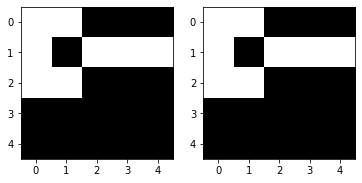

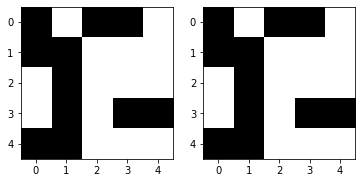

In [19]:
plt.figure()
plt.subplot(121)
plt.imshow(first_frame_camera, cmap='gray')
plt.subplot(122)
plt.imshow(first_frame_reconstructed, cmap='gray')

plt.figure()
plt.subplot(121)
plt.imshow(second_frame_camera, cmap='gray')
plt.subplot(122)
plt.imshow(second_frame_reconstructed, cmap='gray')

 # MEA 3

Here are the first two frames, seen on the camera

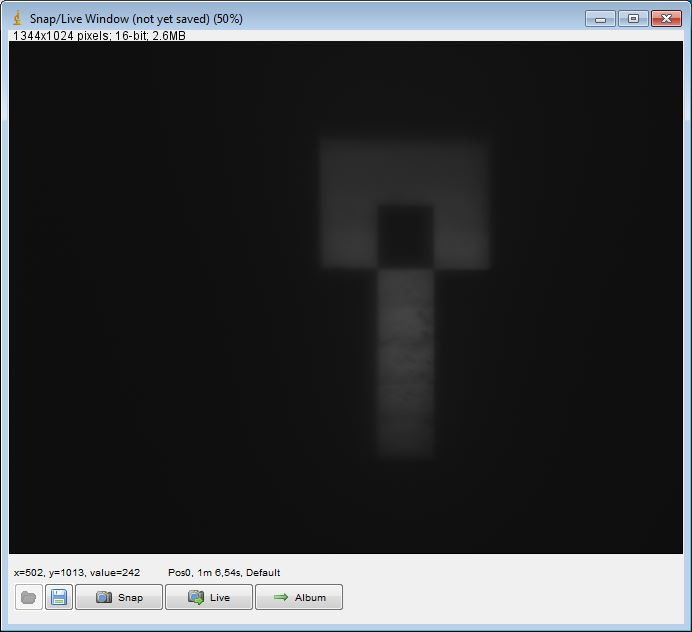

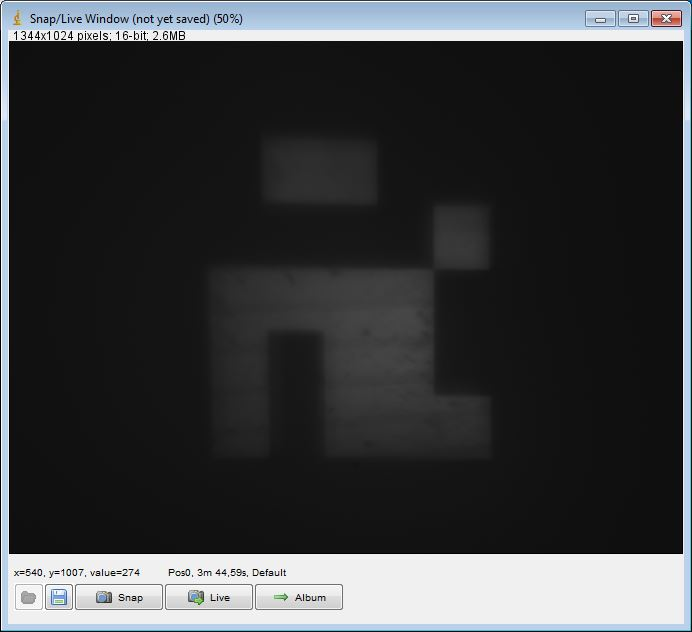

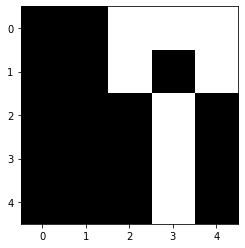

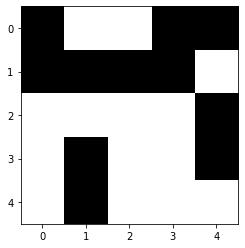

In [46]:
first_frame_camera = np.array([[0,0,1,1,1],
                             [0,0,1,0,1],
                             [0,0,0,1,0],
                             [0,0,0,1,0],
                             [0,0,0,1,0]])

second_frame_camera = np.array([[0,1,1,0,0],
                             [0,0,0,0,1],
                             [1,1,1,1,0],
                             [1,0,1,1,0],
                             [1,0,1,1,1]])

plt.figure()
plt.imshow(first_frame_camera, cmap='gray')

plt.figure()
plt.imshow(second_frame_camera, cmap='gray')

In [47]:
nb_frames = 2
nb_checks_by_side = 5
binary_source_path = "."
rig_nb = 3

checkerboard = np.ones((nb_frames,nb_checks_by_side,nb_checks_by_side), dtype='uint8') 
binary_source_filepath = os.path.join(binary_source_path,"binarysource1000Mbits")
assert os.path.isfile(binary_source_filepath)
checkerboard_object = Checkerboard(nb_checks_by_side, binary_source_filepath, rig_nb, None, None) 
    
for i in tqdm(range(checkerboard.shape[0]), desc="Reconstruction the stimulus"):
    checkerboard[i,:,:] = checkerboard_object.get_image(i)

Reconstruction the stimulus: 100%|██████████| 2/2 [00:00<00:00, 8962.19it/s]


In [48]:
first_frame_reconstructed = checkerboard[0,:,:]
second_frame_reconstructed = checkerboard[1,:,:]

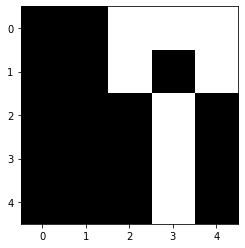

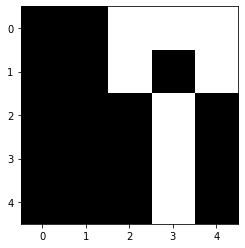

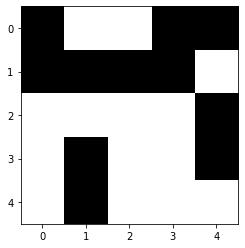

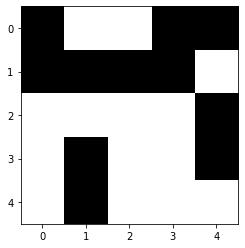

In [49]:
plt.figure()
plt.imshow(first_frame_camera, cmap='gray')

plt.figure()
plt.imshow(first_frame_reconstructed, cmap='gray')

plt.figure()
plt.imshow(second_frame_camera, cmap='gray')

plt.figure()
plt.imshow(second_frame_reconstructed, cmap='gray')

# Conclusion
With the new version of the class Checkerboard the checkerboard has the same polarity and orientation as the one seen on the camera of the RIG